#**유통 판매량 예측 및 재고 최적화**
## **단계2 : 모델링을 위한 데이터 전처리**

# **0.미션**

* 단계1 상품별 데이터셋 만들기
    * 가설로 도출된 변수를 반영한 데이터셋을 상품별로 생성
* 단계2 기초 모델 생성
    * base line model : dense layer만 이용해서 기초 모델 생성
    * LSTM, CNN 알고리즘을 이용해서 기초 모델 생성

* 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|3|6|
|42|FM001|Agricultural products|Grocery|3|5|


# **1.환경설정**

* 세부 요구사항
    * 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 라이브러리 로딩
        * 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### **(1) 경로 설정**

* 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/취업/KT_AIVLE_SCHOOL/week10/Mini_project6/Product_sales_forecast/

/content/drive/MyDrive/취업/KT_AIVLE_SCHOOL/week10/Mini_project6/Product_sales_forecast


In [3]:
path = 'data/'

### **(2) 라이브러리 설치 및 불러오기**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

from keras.models import Sequential
from keras.backend import clear_session
from keras.layers import Dense, LSTM, Conv1D, Flatten
from keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

In [5]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [6]:
# 예측 결과 시각화
def plot_model_result(y_train, y_val, pred) :

    y_train = pd.Series(y_train)
    y_val = pd.Series(y_val)
    y_val.index = range(len(y_train), len(y_train) + len(y_val))

    pred = pd.Series(pred.reshape(-1,), index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

### **(3) 데이터 불러오기**

In [7]:
oil_price = pd.read_csv(path + 'train/oil_price_train.csv')
orders = pd.read_csv(path + 'train/orders_train.csv')
sales = pd.read_csv(path + 'train/sales_train.csv')
products = pd.read_csv(path + 'train/products.csv')
stores = pd.read_csv(path + 'train/stores.csv')

sales['Date'] = pd.to_datetime(sales['Date'] )
oil_price['Date'] = pd.to_datetime(oil_price['Date'] )
orders['Date'] = pd.to_datetime(orders['Date'] )

# **2.데이터셋 구성하기**

* 세부 요구사항
    * 상품코드 별로 각각 데이터셋을 구성해야 합니다.
    * 도출된 변수들을 포함하는 데이터셋을 구성합니다.


>1. 변수 추가: 고객 방문수, weekday, diff, 7일 이동 평균, 요일별 평균 판매량, y (리드타임(2일)후의 판매량)
>2. NaN, 가변수화 등의 전처리 진행

In [8]:
len(sales[(sales['Store_ID'] == 44) & (sales['Product_ID'] == 3)]),len(sales[(sales['Store_ID'] == 44) & (sales['Product_ID'] == 12)]), len(sales[(sales['Store_ID'] == 44) & (sales['Product_ID'] == 42)])

(1152, 1152, 1155)

In [14]:
def make_dataset(STORE_ID, PRODUCT_ID):
    # 데이터 프레임 합치기
    df = sales[(sales['Store_ID'] == STORE_ID) & (sales['Product_ID'] == PRODUCT_ID)]
    df = pd.merge(df, orders, how='left')

    # 변수 생성
    df['Qty_diff'] = df['Qty'].diff()
    df['Qty_7'] = df['Qty'].rolling(7).mean()
    df['weekday'] = df['Date'].dt.weekday

    # 요일별 판매량 평균
    weekday_avg = df.groupby('weekday')['Qty'].mean()
    df['weekday_avg'] = df['weekday'].map(weekday_avg)

    df['y'] = df['Qty'].shift(-2)

    # 결측치 처리
    df['CustomerCount'].interpolate(method='linear', inplace=True)
    df['Qty_7'].fillna(method='bfill', inplace=True)
    df.dropna(inplace=True)

    # 가변수화 처리
    object_cols = ['weekday']
    df = pd.get_dummies(df, columns=object_cols, drop_first=True, dtype=int)

    # Store_ID, Product_ID 열 삭제
    df.drop(['Store_ID', 'Product_ID'], axis=1, inplace=True)

    return df

In [15]:
df_3  = make_dataset(44, 3)
df_12  = make_dataset(44, 12)
df_42  = make_dataset(44, 42)

## **(1) 상품 : 3 - Beverage**

In [16]:
df_3.head(7)

,Date,Qty,CustomerCount,Qty_diff,Qty_7,weekday_avg,y,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
1,2014-01-02,9853.0,4422.0,9853.0,9192.428571,6276.737805,15153.0,0,0,1,0,0,0
2,2014-01-03,8647.0,4167.0,-1206.0,9192.428571,7628.457317,15606.0,0,0,0,1,0,0
3,2014-01-04,15153.0,5341.0,6506.0,9192.428571,11864.363636,7900.0,0,0,0,0,1,0
4,2014-01-05,15606.0,5123.0,453.0,9192.428571,12772.810976,7188.0,0,0,0,0,0,1
5,2014-01-06,7900.0,3917.0,-7706.0,9192.428571,7802.484848,8800.0,0,0,0,0,0,0
6,2014-01-07,7188.0,3663.0,-712.0,9192.428571,7070.333333,6606.0,1,0,0,0,0,0
7,2014-01-08,8800.0,4254.0,1612.0,10449.571429,7653.987879,7051.0,0,1,0,0,0,0


In [17]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1149 entries, 1 to 1149
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           1149 non-null   datetime64[ns]
 1   Qty            1149 non-null   float64       
 2   CustomerCount  1149 non-null   float64       
 3   Qty_diff       1149 non-null   float64       
 4   Qty_7          1149 non-null   float64       
 5   weekday_avg    1149 non-null   float64       
 6   y              1149 non-null   float64       
 7   weekday_1      1149 non-null   int64         
 8   weekday_2      1149 non-null   int64         
 9   weekday_3      1149 non-null   int64         
 10  weekday_4      1149 non-null   int64         
 11  weekday_5      1149 non-null   int64         
 12  weekday_6      1149 non-null   int64         
dtypes: datetime64[ns](1), float64(6), int64(6)
memory usage: 125.7 KB


## **(2) 상품 : 12 - Milk**

In [18]:
df_12.head(7)

,Date,Qty,CustomerCount,Qty_diff,Qty_7,weekday_avg,y,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
1,2014-01-02,9647.0,4422.0,9647.0,8848.857143,7384.045457,14188.0,0,0,1,0,0,0
2,2014-01-03,8879.0,4167.0,-768.0,8848.857143,8889.493902,14490.0,0,0,0,1,0,0
3,2014-01-04,14188.0,5341.0,5309.0,8848.857143,12842.539394,7614.0,0,0,0,0,1,0
4,2014-01-05,14490.0,5123.0,302.0,8848.857143,13709.823171,7124.0,0,0,0,0,0,1
5,2014-01-06,7614.0,3917.0,-6876.0,8848.857143,9266.999370,8683.0,0,0,0,0,0,0
6,2014-01-07,7124.0,3663.0,-490.0,8848.857143,8664.380527,6731.0,1,0,0,0,0,0
7,2014-01-08,8683.0,4254.0,1559.0,10089.285714,9292.938788,6992.0,0,1,0,0,0,0


In [19]:
df_12.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1149 entries, 1 to 1149
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           1149 non-null   datetime64[ns]
 1   Qty            1149 non-null   float64       
 2   CustomerCount  1149 non-null   float64       
 3   Qty_diff       1149 non-null   float64       
 4   Qty_7          1149 non-null   float64       
 5   weekday_avg    1149 non-null   float64       
 6   y              1149 non-null   float64       
 7   weekday_1      1149 non-null   int64         
 8   weekday_2      1149 non-null   int64         
 9   weekday_3      1149 non-null   int64         
 10  weekday_4      1149 non-null   int64         
 11  weekday_5      1149 non-null   int64         
 12  weekday_6      1149 non-null   int64         
dtypes: datetime64[ns](1), float64(6), int64(6)
memory usage: 125.7 KB


## **(3) 상품 : 42 - Agricultural products**

In [20]:
df_42.head(7)

,Date,Qty,CustomerCount,Qty_diff,Qty_7,weekday_avg,y,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
1,2014-01-02,76.0,4422.0,25.0,72.857143,112.012121,78.0,0,0,1,0,0,0
2,2014-01-03,74.0,4167.0,-2.0,72.857143,120.606061,88.0,0,0,0,1,0,0
3,2014-01-04,78.0,5341.0,4.0,72.857143,126.151515,65.0,0,0,0,0,1,0
4,2014-01-05,88.0,5123.0,10.0,72.857143,133.727273,78.0,0,0,0,0,0,1
5,2014-01-06,65.0,3917.0,-23.0,72.857143,90.024242,73.0,0,0,0,0,0,0
6,2014-01-07,78.0,3663.0,13.0,72.857143,103.690909,78.0,1,0,0,0,0,0
7,2014-01-08,73.0,4254.0,-5.0,76.000000,104.406061,96.0,0,1,0,0,0,0


In [21]:
df_42.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1152 entries, 1 to 1152
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           1152 non-null   datetime64[ns]
 1   Qty            1152 non-null   float64       
 2   CustomerCount  1152 non-null   float64       
 3   Qty_diff       1152 non-null   float64       
 4   Qty_7          1152 non-null   float64       
 5   weekday_avg    1152 non-null   float64       
 6   y              1152 non-null   float64       
 7   weekday_1      1152 non-null   int64         
 8   weekday_2      1152 non-null   int64         
 9   weekday_3      1152 non-null   int64         
 10  weekday_4      1152 non-null   int64         
 11  weekday_5      1152 non-null   int64         
 12  weekday_6      1152 non-null   int64         
dtypes: datetime64[ns](1), float64(6), int64(6)
memory usage: 126.0 KB


# **3.Baseline Model**

* **세부 요구사항**
    * 데이터 준비
        * 스케일링
            * 교과서 적으로는 데이터 분할 이후 스케일링하는게 맞지만, 데이터 건수가 충분히 크다면, 스케일링을 먼저 하기도 합니다.
            * 여기서는 먼저 스케일링을 한 후 데이터 분할을 합니다.
        * 데이터 분할
            * 검증셋 구성 : 학습용 데이터에서 최근 60일을 검증셋으로 사용.

    * 모델링
        * Dense Layer 1개(output layer)만으로 모델을 생성합니다.
        * 모델의 검증 성능을 평가하고 기록합니다.
        * 평가 지표 : RMSE, MAE, MAPE, R2 Score


In [22]:
def data_split(df, target, val_size):
    # X, y 분할
    X = df.drop([target, 'Date'], axis=1)
    y = df.loc[:, target]

    # 스케일링
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_s = scaler_x.fit_transform(X)
    y_s = scaler_y.fit_transform(y.values.reshape(-1, 1))

    # 데이터 분할
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=val_size, shuffle=False, random_state=42) # 스케일링 안됨 : 평가에 사용
    X_train_s, X_valid_s, y_train_s, y_valid_s = train_test_split(X_s, y_s, test_size=val_size,  shuffle=False, random_state=42) # 스케일링 됨 : 학습에 사용

    return X_train, X_valid, y_train, y_valid, X_train_s, X_valid_s, y_train_s, y_valid_s, scaler_y

In [23]:
def base_model_training(nfeatures, epochs):
    clear_session()

    model = Sequential([Dense(1)])
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')

    history = model.fit(X_train_s, y_train_s, validation_split=0.2, epochs=epochs).history

    return history, model

## **(1) 상품 : 3 - Beverage**

### **1) 데이터 준비**

In [24]:
target = 'y'
val_size = 60

X_train, X_valid, y_train, y_valid, X_train_s, X_valid_s, y_train_s, y_valid_s, scaler_y = data_split(df_3, target, val_size)

In [25]:
X_train_s.shape, X_valid_s.shape, y_train_s.shape, y_valid_s.shape

((1089, 11), (60, 11), (1089, 1), (60, 1))

### **2) 모델링**

In [26]:
nfeatures = X_train.shape[1]
epochs = 50

history, model = base_model_training(nfeatures, epochs)

Epoch 1/50
28/28 [==============================] - 1s 9ms/step - loss: 0.1502 - val_loss: 0.1216
Epoch 2/50
28/28 [==============================] - 0s 3ms/step - loss: 0.1035 - val_loss: 0.0822
Epoch 3/50
28/28 [==============================] - 0s 3ms/step - loss: 0.0749 - val_loss: 0.0594
Epoch 4/50
28/28 [==============================] - 0s 3ms/step - loss: 0.0569 - val_loss: 0.0453
Epoch 5/50
28/28 [==============================] - 0s 3ms/step - loss: 0.0452 - val_loss: 0.0357
Epoch 6/50
28/28 [==============================] - 0s 3ms/step - loss: 0.0370 - val_loss: 0.0293
Epoch 7/50
28/28 [==============================] - 0s 3ms/step - loss: 0.0309 - val_loss: 0.0245
Epoch 8/50
28/28 [==============================] - 0s 3ms/step - loss: 0.0263 - val_loss: 0.0208
Epoch 9/50
28/28 [==============================] - 0s 3ms/step - loss: 0.0227 - val_loss: 0.0180
Epoch 10/50
28/28 [==============================] - 0s 3ms/step - loss: 0.0199 - val_loss: 0.0158
Epoch 11/50
28/28 [

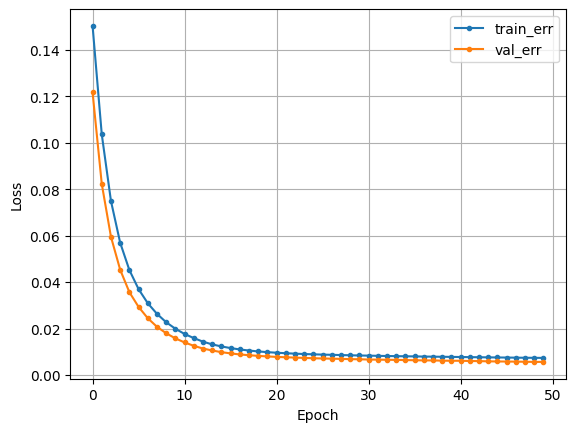

In [27]:
dl_history_plot(history)

2/2 [==============================] - 0s 14ms/step


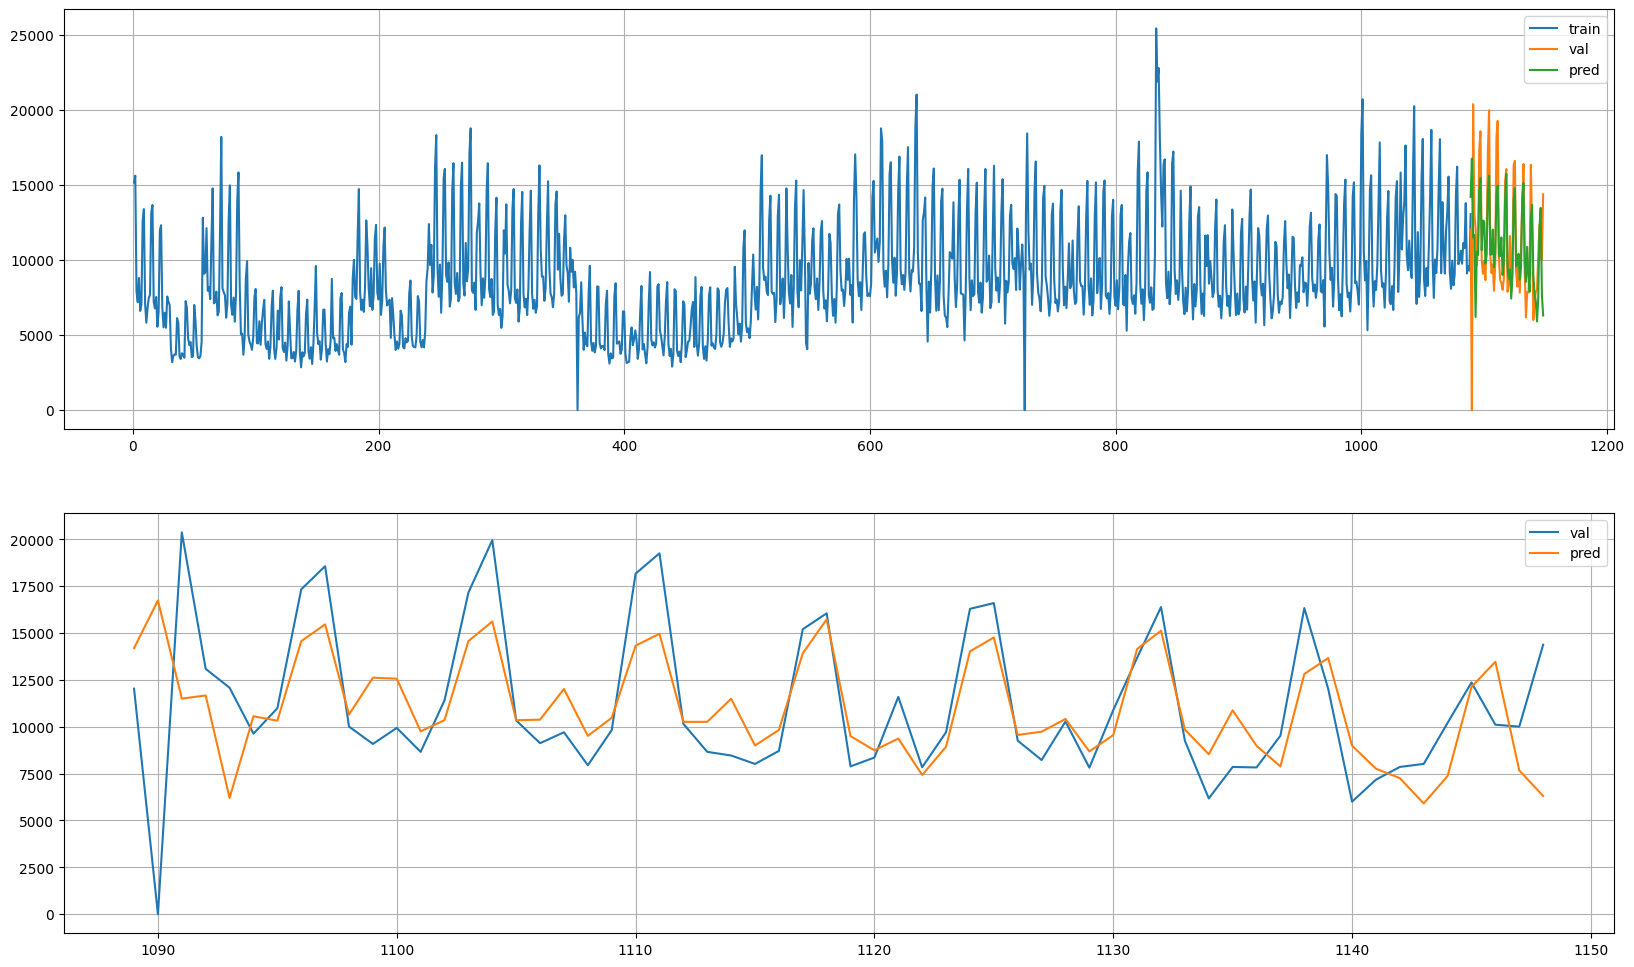

In [28]:
pred = model.predict(X_valid_s)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

plot_model_result(y_train, y_valid, pred)

In [29]:
# 평가
print('RMSE:', round(mean_squared_error(y_valid, pred, squared=False), 2))
print('MAE :', round(mean_absolute_error(y_valid, pred), 2))
print('MAPE:', round(mean_absolute_percentage_error(y_valid, pred), 2))
print('R2  :', round(r2_score(y_valid, pred), 2))

RMSE: 3383.28
MAE : 2220.09
MAPE: 1.2561257708333128e+18
R2  : 0.27


## **(2) 상품 : 12 - Milk**

### **1) 데이터 준비**

In [30]:
target = 'y'
val_size = 60

X_train, X_valid, y_train, y_valid, X_train_s, X_valid_s, y_train_s, y_valid_s, scaler_y = data_split(df_12, target, val_size)

In [31]:
X_train_s.shape, X_valid_s.shape, y_train_s.shape, y_valid_s.shape

((1089, 11), (60, 11), (1089, 1), (60, 1))

### **2) 모델링**

In [32]:
nfeatures = X_train.shape[1]
epochs = 50

history, model = base_model_training(nfeatures, epochs)

Epoch 1/50
28/28 [==============================] - 1s 7ms/step - loss: 0.2419 - val_loss: 0.2263
Epoch 2/50
28/28 [==============================] - 0s 3ms/step - loss: 0.2150 - val_loss: 0.2042
Epoch 3/50
28/28 [==============================] - 0s 3ms/step - loss: 0.1924 - val_loss: 0.1839
Epoch 4/50
28/28 [==============================] - 0s 3ms/step - loss: 0.1728 - val_loss: 0.1656
Epoch 5/50
28/28 [==============================] - 0s 3ms/step - loss: 0.1548 - val_loss: 0.1487
Epoch 6/50
28/28 [==============================] - 0s 3ms/step - loss: 0.1389 - val_loss: 0.1336
Epoch 7/50
28/28 [==============================] - 0s 4ms/step - loss: 0.1242 - val_loss: 0.1195
Epoch 8/50
28/28 [==============================] - 0s 3ms/step - loss: 0.1106 - val_loss: 0.1063
Epoch 9/50
28/28 [==============================] - 0s 3ms/step - loss: 0.0987 - val_loss: 0.0953
Epoch 10/50
28/28 [==============================] - 0s 3ms/step - loss: 0.0882 - val_loss: 0.0851
Epoch 11/50
28/28 [

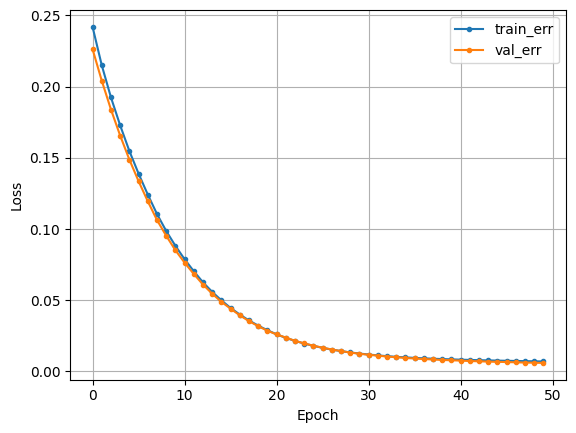

In [33]:
dl_history_plot(history)

2/2 [==============================] - 0s 10ms/step


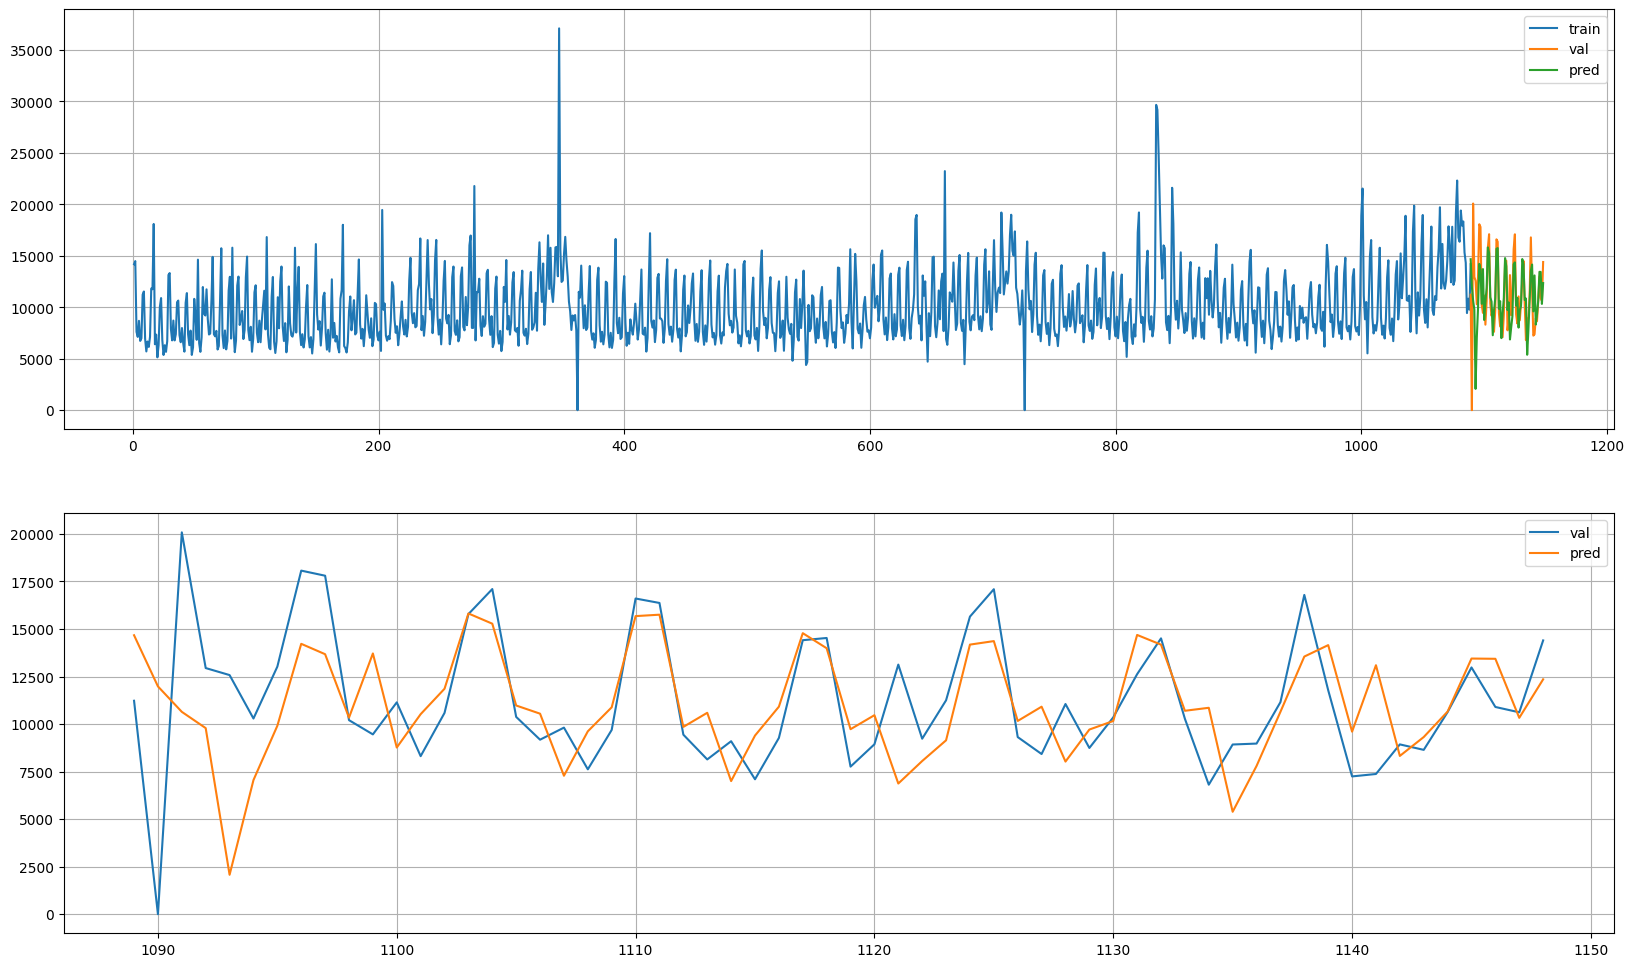

In [34]:
pred = model.predict(X_valid_s)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

plot_model_result(y_train, y_valid, pred)

In [35]:
# 평가
print('RMSE:', round(mean_squared_error(y_valid, pred, squared=False), 2))
print('MAE :', round(mean_absolute_error(y_valid, pred), 2))
print('MAPE:', round(mean_absolute_percentage_error(y_valid, pred), 2))
print('R2  :', round(r2_score(y_valid, pred), 2))

RMSE: 3326.27
MAE : 2353.06
MAPE: 8.993022151812448e+17
R2  : 0.1


## **(3) 상품 : 42 - Agricultural products**

### **1) 데이터 준비**

In [36]:
target = 'y'
val_size = 60

X_train, X_valid, y_train, y_valid, X_train_s, X_valid_s, y_train_s, y_valid_s, scaler_y = data_split(df_42, target, val_size)

In [37]:
X_train_s.shape, X_valid_s.shape, y_train_s.shape, y_valid_s.shape

((1092, 11), (60, 11), (1092, 1), (60, 1))

### **2) 모델링**

In [38]:
nfeatures = X_train.shape[1]
epochs = 50

history, model = base_model_training(nfeatures, epochs)

Epoch 1/50
28/28 [==============================] - 1s 7ms/step - loss: 0.2618 - val_loss: 0.2813
Epoch 2/50
28/28 [==============================] - 0s 4ms/step - loss: 0.2345 - val_loss: 0.2698
Epoch 3/50
28/28 [==============================] - 0s 3ms/step - loss: 0.2134 - val_loss: 0.2503
Epoch 4/50
28/28 [==============================] - 0s 3ms/step - loss: 0.1947 - val_loss: 0.2306
Epoch 5/50
28/28 [==============================] - 0s 2ms/step - loss: 0.1778 - val_loss: 0.2138
Epoch 6/50
28/28 [==============================] - 0s 3ms/step - loss: 0.1625 - val_loss: 0.1962
Epoch 7/50
28/28 [==============================] - 0s 3ms/step - loss: 0.1484 - val_loss: 0.1800
Epoch 8/50
28/28 [==============================] - 0s 3ms/step - loss: 0.1356 - val_loss: 0.1645
Epoch 9/50
28/28 [==============================] - 0s 3ms/step - loss: 0.1236 - val_loss: 0.1519
Epoch 10/50
28/28 [==============================] - 0s 3ms/step - loss: 0.1130 - val_loss: 0.1397
Epoch 11/50
28/28 [

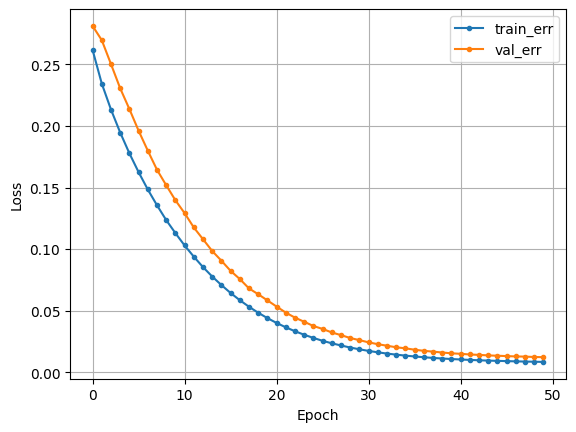

In [39]:
dl_history_plot(history)

2/2 [==============================] - 0s 5ms/step


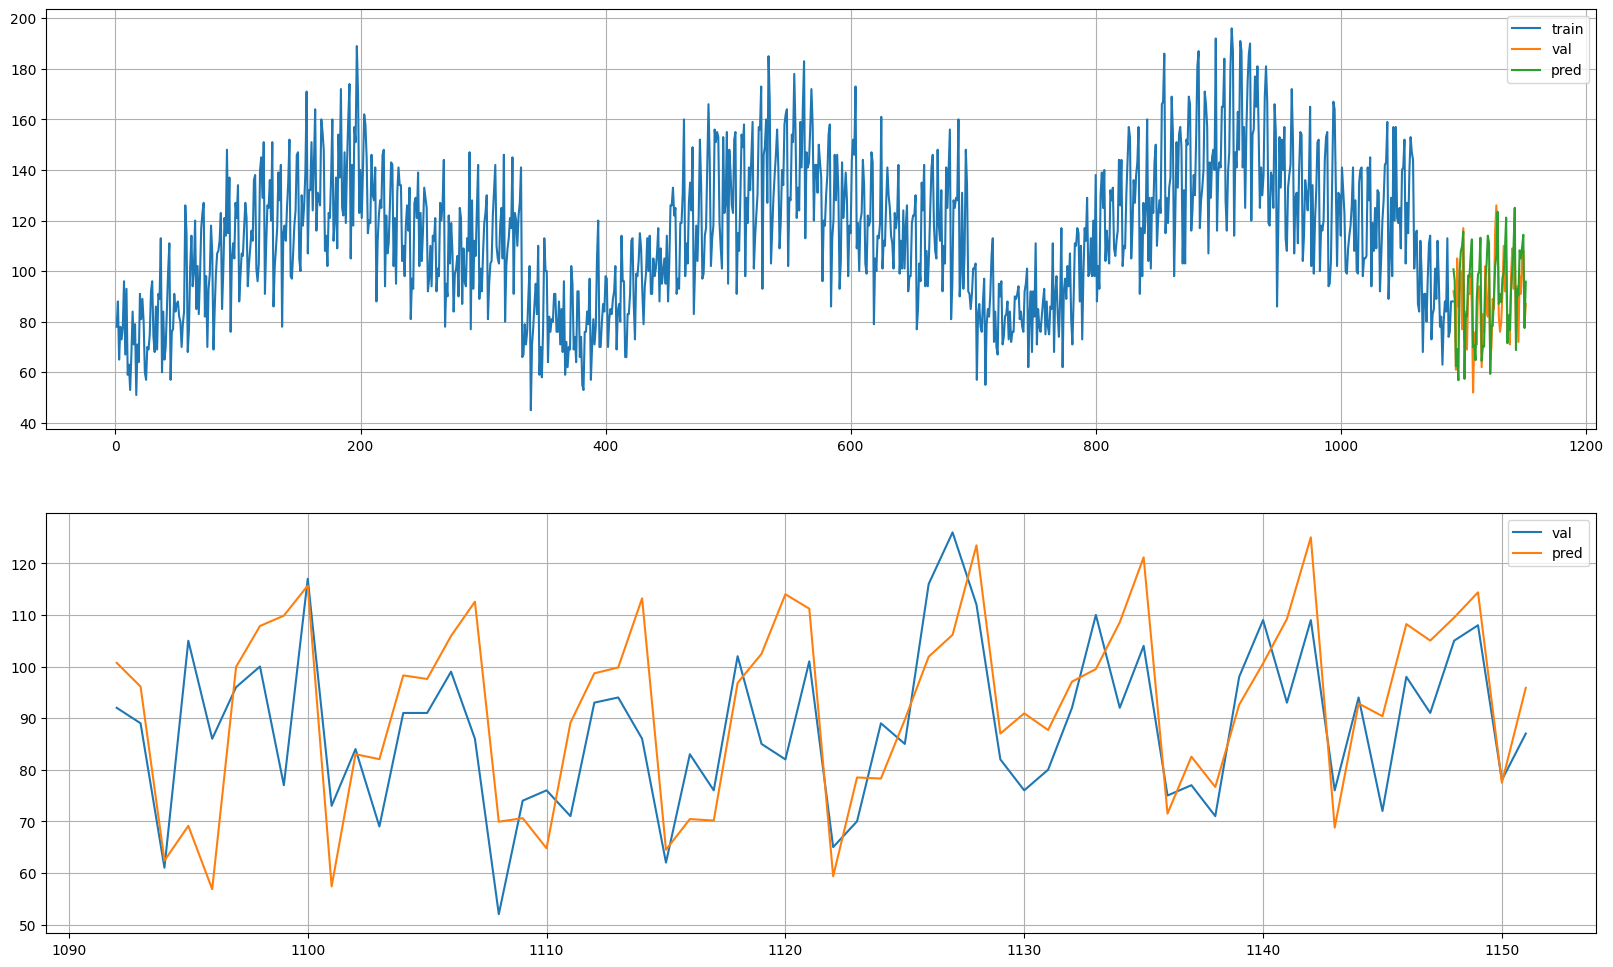

In [40]:
pred = model.predict(X_valid_s)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

plot_model_result(y_train, y_valid, pred)

In [41]:
# 평가
print('RMSE:', round(mean_squared_error(y_valid, pred, squared=False), 2))
print('MAE :', round(mean_absolute_error(y_valid, pred), 2))
print('MAPE:', round(mean_absolute_percentage_error(y_valid, pred), 2))
print('R2  :', round(r2_score(y_valid, pred), 2))

RMSE: 13.81
MAE : 11.07
MAPE: 0.13
R2  : 0.17


# **4.LSTM, CNN 초기 모델**

* **세부 요구사항**
    * 3차원 데이터 구조 만들기
        * timestep 수는 적절한 간격으로 한가지 경우만 지정을 합니다.
    * LSTM, CNN 기반 초기 모델 생성
        * 성능 보다는 코드 틀을 작성하는데 집중합시다.
        * 노드 혹은 필터 수와 크기는 초기값으로 적절하게 지정해 봅시다.

In [42]:
def temporalize(x, y, timesteps):
    output_X = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        output_X.append(x.iloc[i:i+timesteps])
        output_y.append(y.iloc[i+timesteps-1])
    return np.array(output_X), np.array(output_y)

def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return flattened_X

def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
    return X

In [43]:
def data_split2(df, target, val_size, timesteps):
    # X, y 분할
    X = df.drop([target, 'Date'], axis=1)
    y = df.loc[:, target]

    # 3차원 구조로 만들기
    X2, y2 = temporalize(X, y, timesteps)

    # 데이터 분할
    X_train, X_valid, y_train, y_valid = train_test_split(X2, y2, test_size=val_size, shuffle=False, random_state=42)

    # 2차원으로 변환하여 스케일러 생성
    scaler = MinMaxScaler().fit(flatten(X_train))

    # 3차원 데이터에 스테일러 적용
    X_train_s = scale(X_train, scaler)
    X_valid_s = scale(X_valid, scaler)

    # y에 대한 스케일링(최적화를 위해)
    scaler_y = MinMaxScaler()
    y_train_s = scaler_y.fit_transform(y_train.reshape(-1,1))
    y_valid_s = scaler_y.transform(y_valid.reshape(-1,1))

    return X_train, X_valid, y_train, y_valid, X_train_s, X_valid_s, y_train_s, y_valid_s, scaler_y

In [44]:
def LSTM_model_training(nfeatures, epochs, timesteps):
    clear_session()

    model = Sequential([LSTM(32, input_shape=(timesteps, nfeatures)),
                        Dense(1)])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    history = model.fit(X_train_s, y_train_s, validation_split=0.2, epochs=epochs).history

    return history, model

## **(1) LSTM 초기 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

In [45]:
target = 'y'
val_size = 60
timesteps = 7

X_train, X_valid, y_train, y_valid, X_train_s, X_valid_s, y_train_s, y_valid_s, scaler_y = data_split2(df_3, target, val_size, timesteps)

In [46]:
X_train_s.shape, X_valid_s.shape, y_train_s.shape, y_valid_s.shape

((1083, 7, 11), (60, 7, 11), (1083, 1), (60, 1))

* **모델링**

In [47]:
nfeatures = X_train_s.shape[2]
epochs = 50

history, model = LSTM_model_training(nfeatures, epochs, timesteps)

Epoch 1/50
28/28 [==============================] - 3s 25ms/step - loss: 0.0303 - val_loss: 0.0136
Epoch 2/50
28/28 [==============================] - 0s 6ms/step - loss: 0.0122 - val_loss: 0.0088
Epoch 3/50
28/28 [==============================] - 0s 7ms/step - loss: 0.0088 - val_loss: 0.0059
Epoch 4/50
28/28 [==============================] - 0s 7ms/step - loss: 0.0071 - val_loss: 0.0048
Epoch 5/50
28/28 [==============================] - 0s 7ms/step - loss: 0.0064 - val_loss: 0.0047
Epoch 6/50
28/28 [==============================] - 0s 6ms/step - loss: 0.0063 - val_loss: 0.0049
Epoch 7/50
28/28 [==============================] - 0s 7ms/step - loss: 0.0061 - val_loss: 0.0041
Epoch 8/50
28/28 [==============================] - 0s 7ms/step - loss: 0.0059 - val_loss: 0.0049
Epoch 9/50
28/28 [==============================] - 0s 7ms/step - loss: 0.0060 - val_loss: 0.0042
Epoch 10/50
28/28 [==============================] - 0s 6ms/step - loss: 0.0057 - val_loss: 0.0039
Epoch 11/50
28/28 

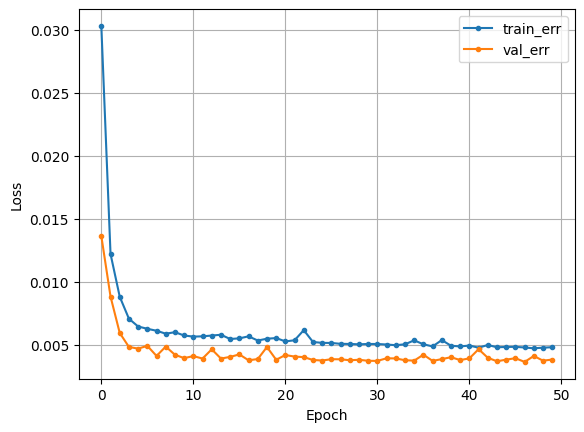

In [48]:
dl_history_plot(history)

2/2 [==============================] - 1s 12ms/step


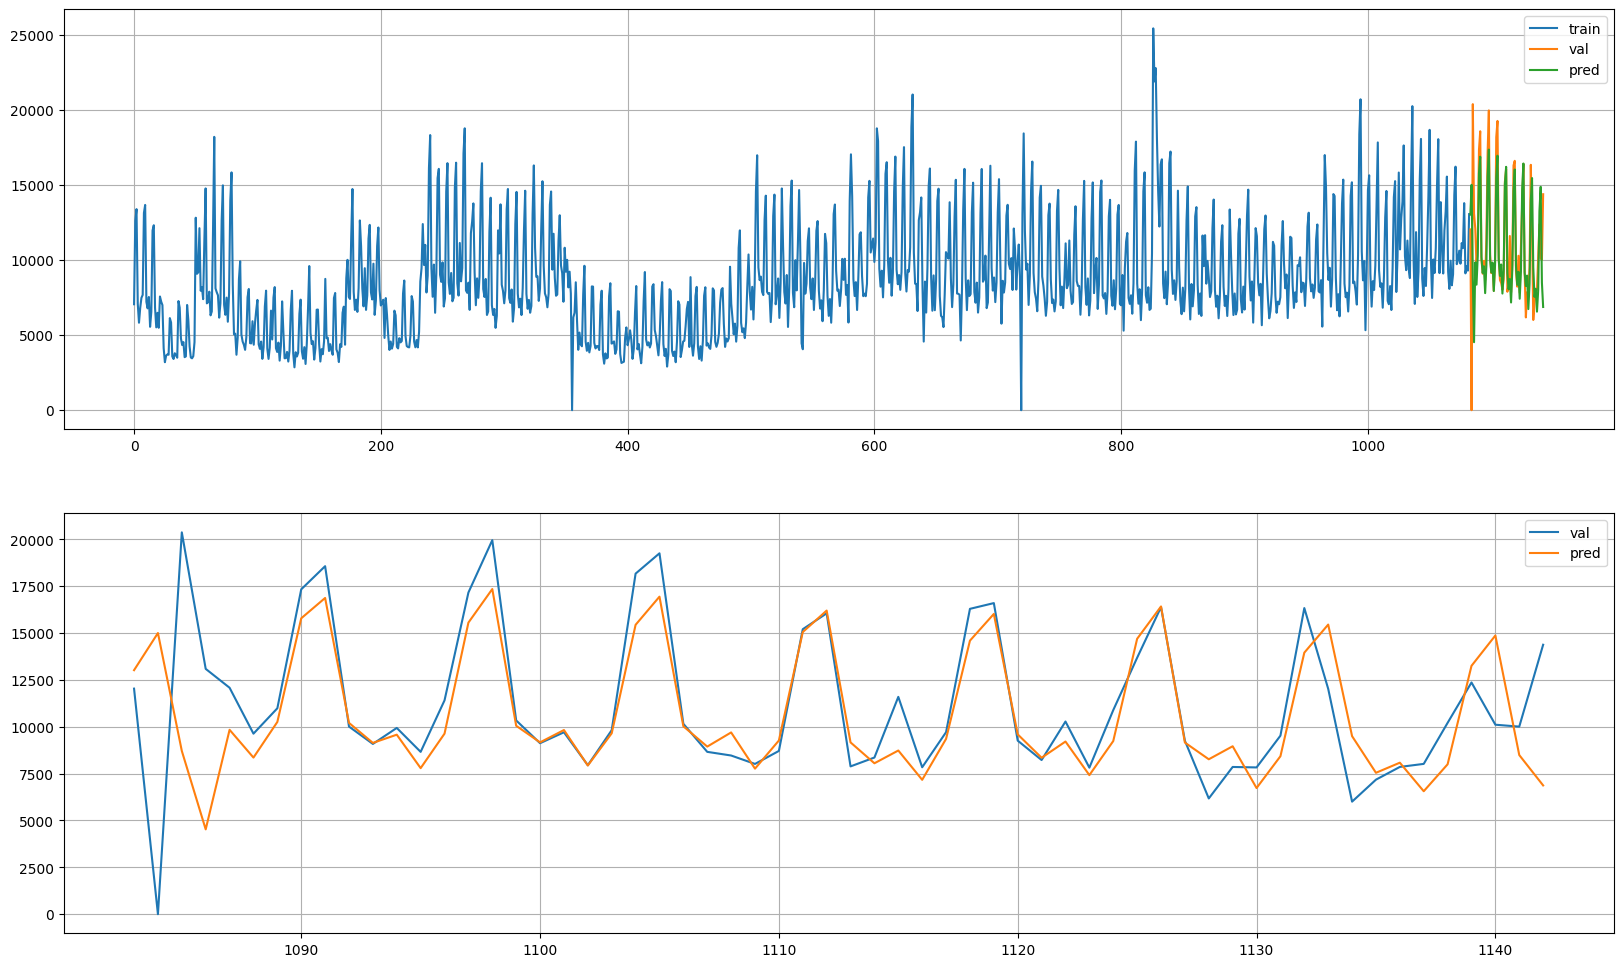

In [49]:
pred = model.predict(X_valid_s)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

plot_model_result(y_train, y_valid, pred)

In [50]:
# 평가
print('RMSE:', round(mean_squared_error(y_valid, pred, squared=False), 2))
print('MAE :', round(mean_absolute_error(y_valid, pred), 2))
print('MAPE:', round(mean_absolute_percentage_error(y_valid, pred), 2))
print('R2  :', round(r2_score(y_valid, pred), 2))

RMSE: 3219.38
MAE : 1761.19
MAPE: 1.125838554093794e+18
R2  : 0.34


### **2) 상품 : 12 - Milk**

In [51]:
target = 'y'
val_size = 60
timesteps = 7

X_train, X_valid, y_train, y_valid, X_train_s, X_valid_s, y_train_s, y_valid_s, scaler_y = data_split2(df_12, target, val_size, timesteps)

In [52]:
X_train_s.shape, X_valid_s.shape, y_train_s.shape, y_valid_s.shape

((1083, 7, 11), (60, 7, 11), (1083, 1), (60, 1))

* **모델링**

In [53]:
nfeatures = X_train_s.shape[2]
epochs = 50

history, model = LSTM_model_training(nfeatures, epochs, timesteps)

Epoch 1/50
28/28 [==============================] - 4s 24ms/step - loss: 0.0125 - val_loss: 0.0069
Epoch 2/50
28/28 [==============================] - 0s 7ms/step - loss: 0.0060 - val_loss: 0.0041
Epoch 3/50
28/28 [==============================] - 0s 6ms/step - loss: 0.0049 - val_loss: 0.0040
Epoch 4/50
28/28 [==============================] - 0s 6ms/step - loss: 0.0048 - val_loss: 0.0036
Epoch 5/50
28/28 [==============================] - 0s 6ms/step - loss: 0.0046 - val_loss: 0.0040
Epoch 6/50
28/28 [==============================] - 0s 7ms/step - loss: 0.0046 - val_loss: 0.0033
Epoch 7/50
28/28 [==============================] - 0s 6ms/step - loss: 0.0045 - val_loss: 0.0041
Epoch 8/50
28/28 [==============================] - 0s 7ms/step - loss: 0.0048 - val_loss: 0.0032
Epoch 9/50
28/28 [==============================] - 0s 7ms/step - loss: 0.0045 - val_loss: 0.0033
Epoch 10/50
28/28 [==============================] - 0s 7ms/step - loss: 0.0045 - val_loss: 0.0036
Epoch 11/50
28/28 

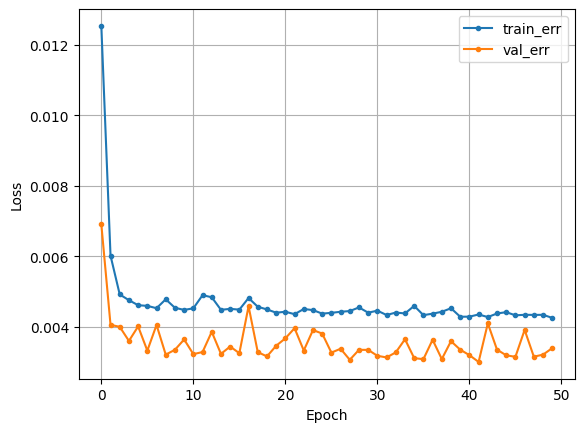

In [54]:
dl_history_plot(history)

2/2 [==============================] - 1s 14ms/step


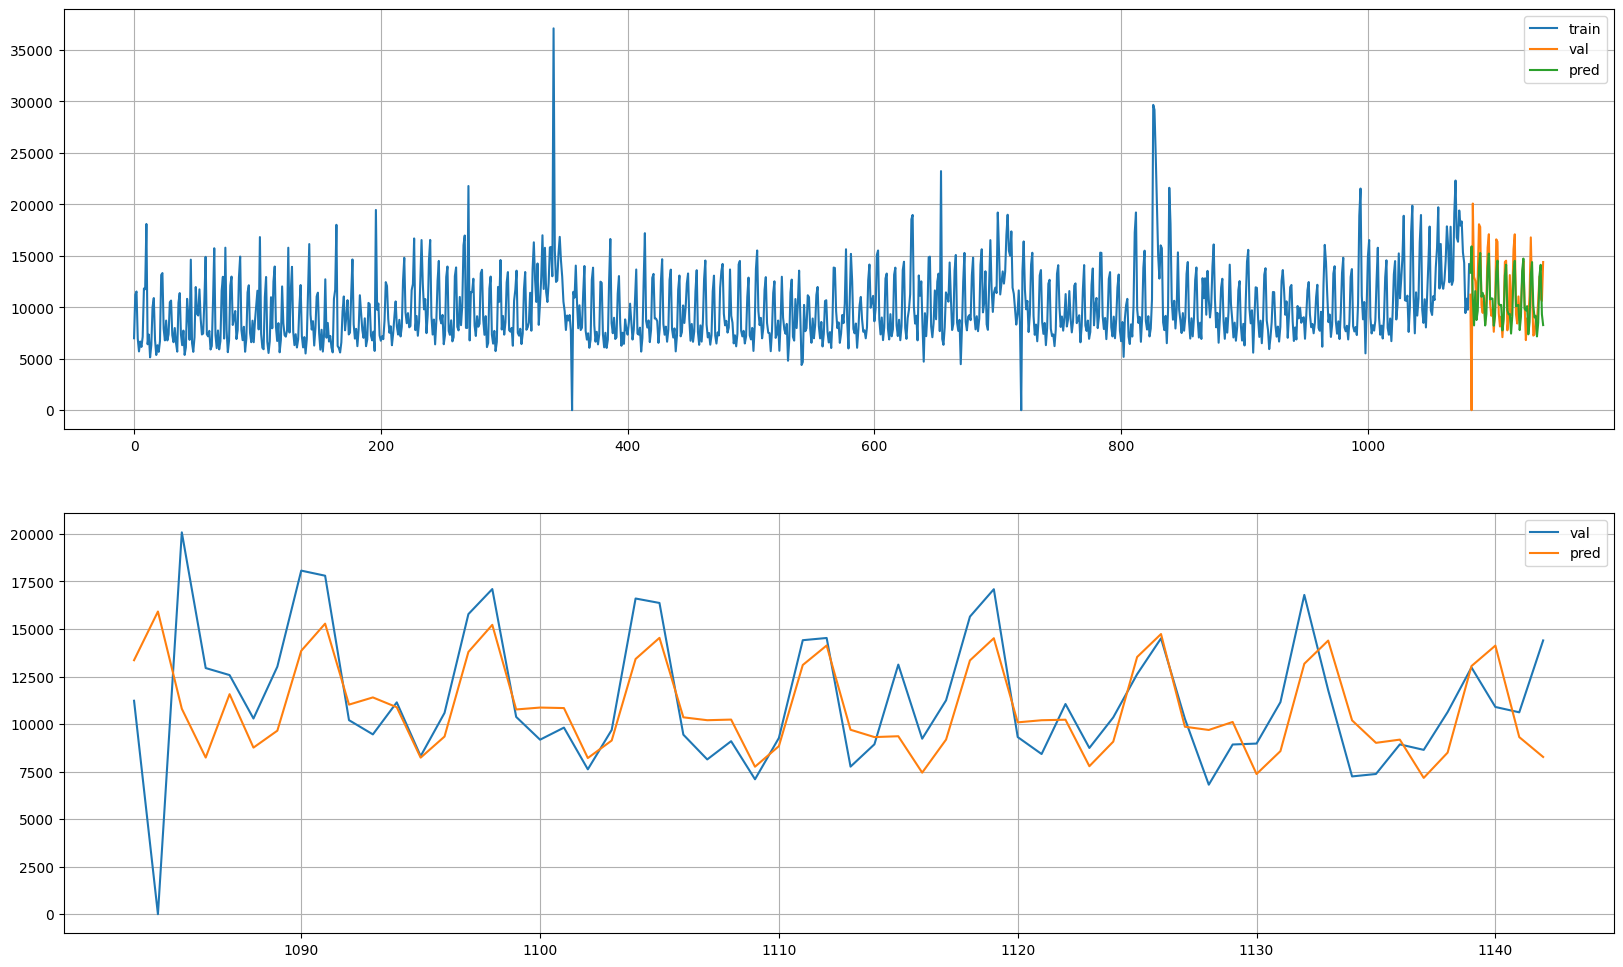

In [55]:
pred = model.predict(X_valid_s)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

plot_model_result(y_train, y_valid, pred)

In [56]:
# 평가
print('RMSE:', round(mean_squared_error(y_valid, pred, squared=False), 2))
print('MAE :', round(mean_absolute_error(y_valid, pred), 2))
print('MAPE:', round(mean_absolute_percentage_error(y_valid, pred), 2))
print('R2  :', round(r2_score(y_valid, pred), 2))

RMSE: 3156.94
MAE : 2078.53
MAPE: 1.1949297390607575e+18
R2  : 0.19


### **3) 상품 : 42 - Agricultural products**

In [57]:
target = 'y'
val_size = 60
timesteps = 7

X_train, X_valid, y_train, y_valid, X_train_s, X_valid_s, y_train_s, y_valid_s, scaler_y = data_split2(df_42, target, val_size, timesteps)

In [58]:
X_train_s.shape, X_valid_s.shape, y_train_s.shape, y_valid_s.shape

((1086, 7, 11), (60, 7, 11), (1086, 1), (60, 1))

* **모델링**

In [59]:
nfeatures = X_train_s.shape[2]
epochs = 50

history, model = LSTM_model_training(nfeatures, epochs, timesteps)

Epoch 1/50
28/28 [==============================] - 3s 24ms/step - loss: 0.0433 - val_loss: 0.0315
Epoch 2/50
28/28 [==============================] - 0s 6ms/step - loss: 0.0153 - val_loss: 0.0176
Epoch 3/50
28/28 [==============================] - 0s 9ms/step - loss: 0.0105 - val_loss: 0.0127
Epoch 4/50
28/28 [==============================] - 0s 13ms/step - loss: 0.0085 - val_loss: 0.0105
Epoch 5/50
28/28 [==============================] - 0s 12ms/step - loss: 0.0078 - val_loss: 0.0101
Epoch 6/50
28/28 [==============================] - 0s 12ms/step - loss: 0.0074 - val_loss: 0.0094
Epoch 7/50
28/28 [==============================] - 0s 11ms/step - loss: 0.0071 - val_loss: 0.0091
Epoch 8/50
28/28 [==============================] - 0s 10ms/step - loss: 0.0069 - val_loss: 0.0093
Epoch 9/50
28/28 [==============================] - 0s 9ms/step - loss: 0.0067 - val_loss: 0.0085
Epoch 10/50
28/28 [==============================] - 0s 10ms/step - loss: 0.0067 - val_loss: 0.0084
Epoch 11/50


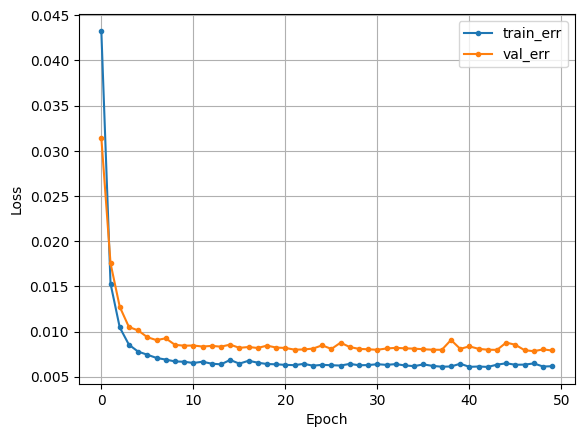

In [60]:
dl_history_plot(history)

2/2 [==============================] - 0s 8ms/step


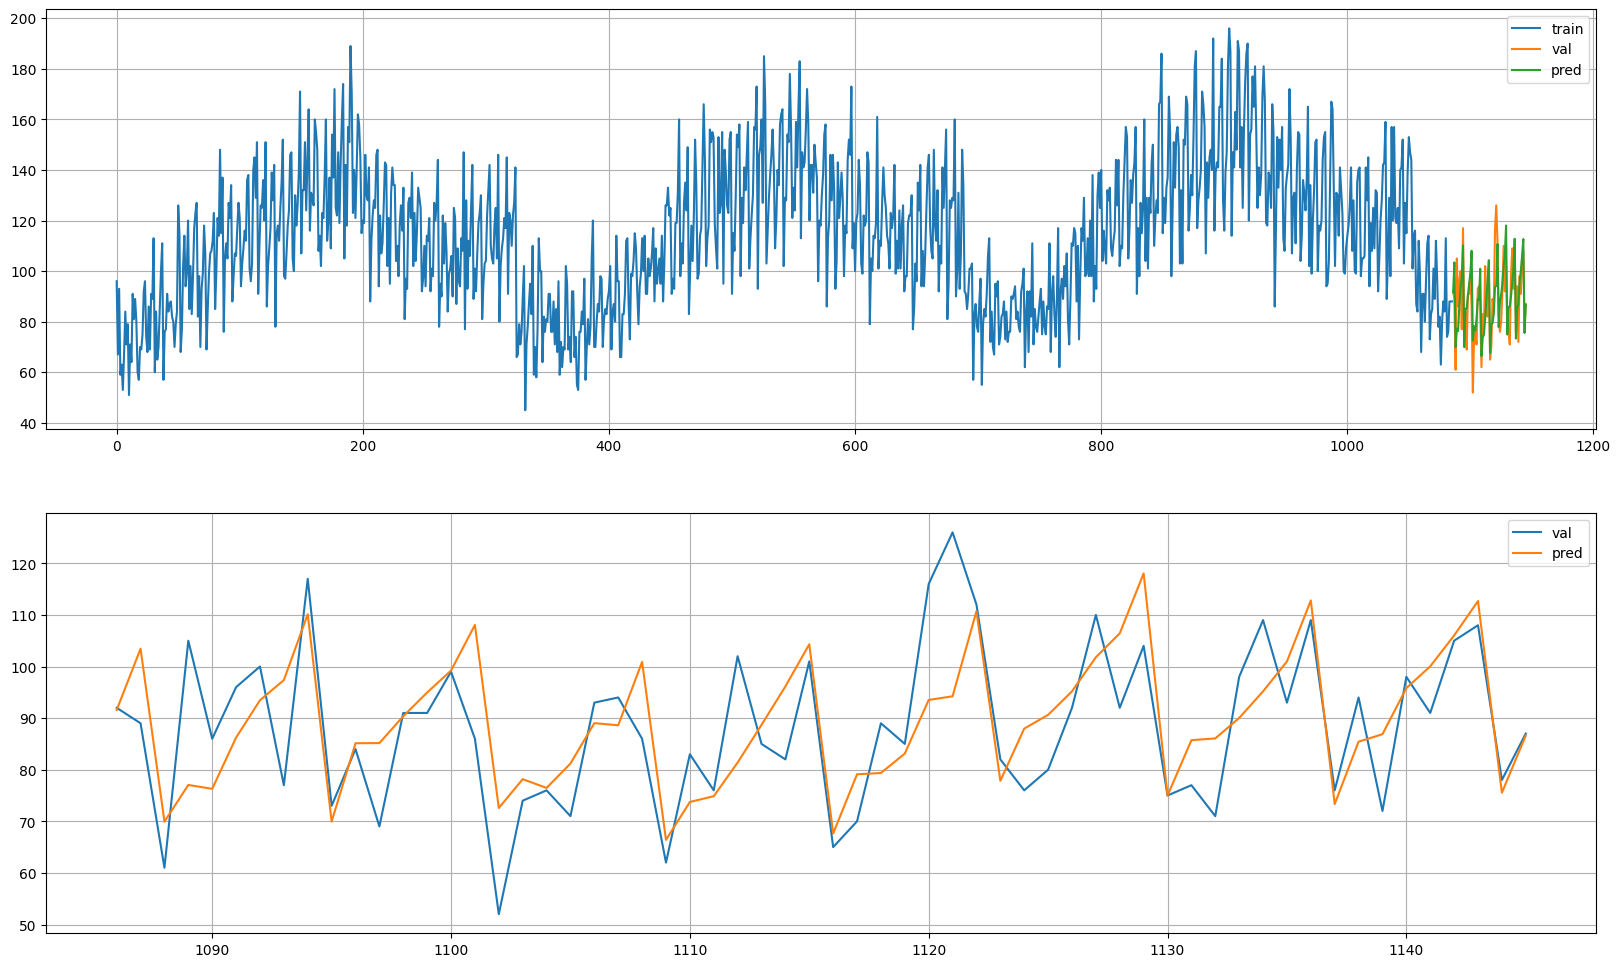

In [61]:
pred = model.predict(X_valid_s)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

plot_model_result(y_train, y_valid, pred)

In [62]:
# 평가
print('RMSE:', round(mean_squared_error(y_valid, pred, squared=False), 2))
print('MAE :', round(mean_absolute_error(y_valid, pred), 2))
print('MAPE:', round(mean_absolute_percentage_error(y_valid, pred), 2))
print('R2  :', round(r2_score(y_valid, pred), 2))

RMSE: 11.27
MAE : 8.62
MAPE: 0.1
R2  : 0.45


## **(2) CNN 초기 모델링**

In [63]:
def CNN_model_training(nfeatures, epochs, timesteps):
    clear_session()

    model = Sequential([Conv1D(32, 7, input_shape=(timesteps, nfeatures), activation='relu', padding='same'),
                        Flatten(),
                        Dense(1)])
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')

    history = model.fit(X_train_s, y_train_s, validation_split=0.2, epochs=epochs).history

    return history, model

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

In [64]:
target = 'y'
val_size = 60
timesteps = 7

X_train, X_valid, y_train, y_valid, X_train_s, X_valid_s, y_train_s, y_valid_s, scaler_y = data_split2(df_3, target, val_size, timesteps)

In [65]:
X_train_s.shape, X_valid_s.shape, y_train_s.shape, y_valid_s.shape

((1083, 7, 11), (60, 7, 11), (1083, 1), (60, 1))

* **모델링**

In [66]:
nfeatures = X_train_s.shape[2]
epochs = 50

history, model = CNN_model_training(nfeatures, epochs, timesteps)

Epoch 1/50
28/28 [==============================] - 1s 8ms/step - loss: 0.0381 - val_loss: 0.0118
Epoch 2/50
28/28 [==============================] - 0s 3ms/step - loss: 0.0077 - val_loss: 0.0048
Epoch 3/50
28/28 [==============================] - 0s 3ms/step - loss: 0.0063 - val_loss: 0.0044
Epoch 4/50
28/28 [==============================] - 0s 3ms/step - loss: 0.0063 - val_loss: 0.0046
Epoch 5/50
28/28 [==============================] - 0s 3ms/step - loss: 0.0058 - val_loss: 0.0048
Epoch 6/50
28/28 [==============================] - 0s 3ms/step - loss: 0.0058 - val_loss: 0.0050
Epoch 7/50
28/28 [==============================] - 0s 5ms/step - loss: 0.0056 - val_loss: 0.0044
Epoch 8/50
28/28 [==============================] - 0s 5ms/step - loss: 0.0053 - val_loss: 0.0040
Epoch 9/50
28/28 [==============================] - 0s 5ms/step - loss: 0.0051 - val_loss: 0.0042
Epoch 10/50
28/28 [==============================] - 0s 5ms/step - loss: 0.0051 - val_loss: 0.0039
Epoch 11/50
28/28 [

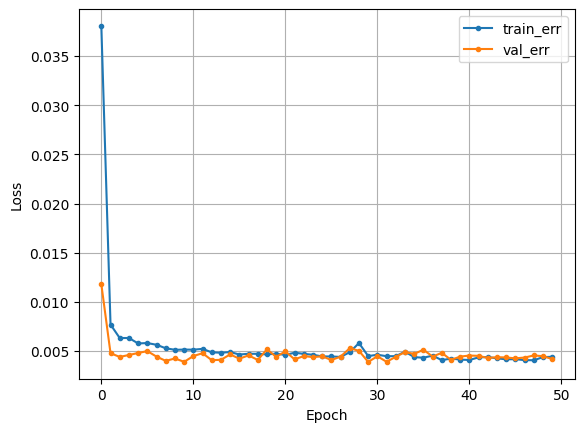

In [67]:
dl_history_plot(history)

2/2 [==============================] - 0s 6ms/step


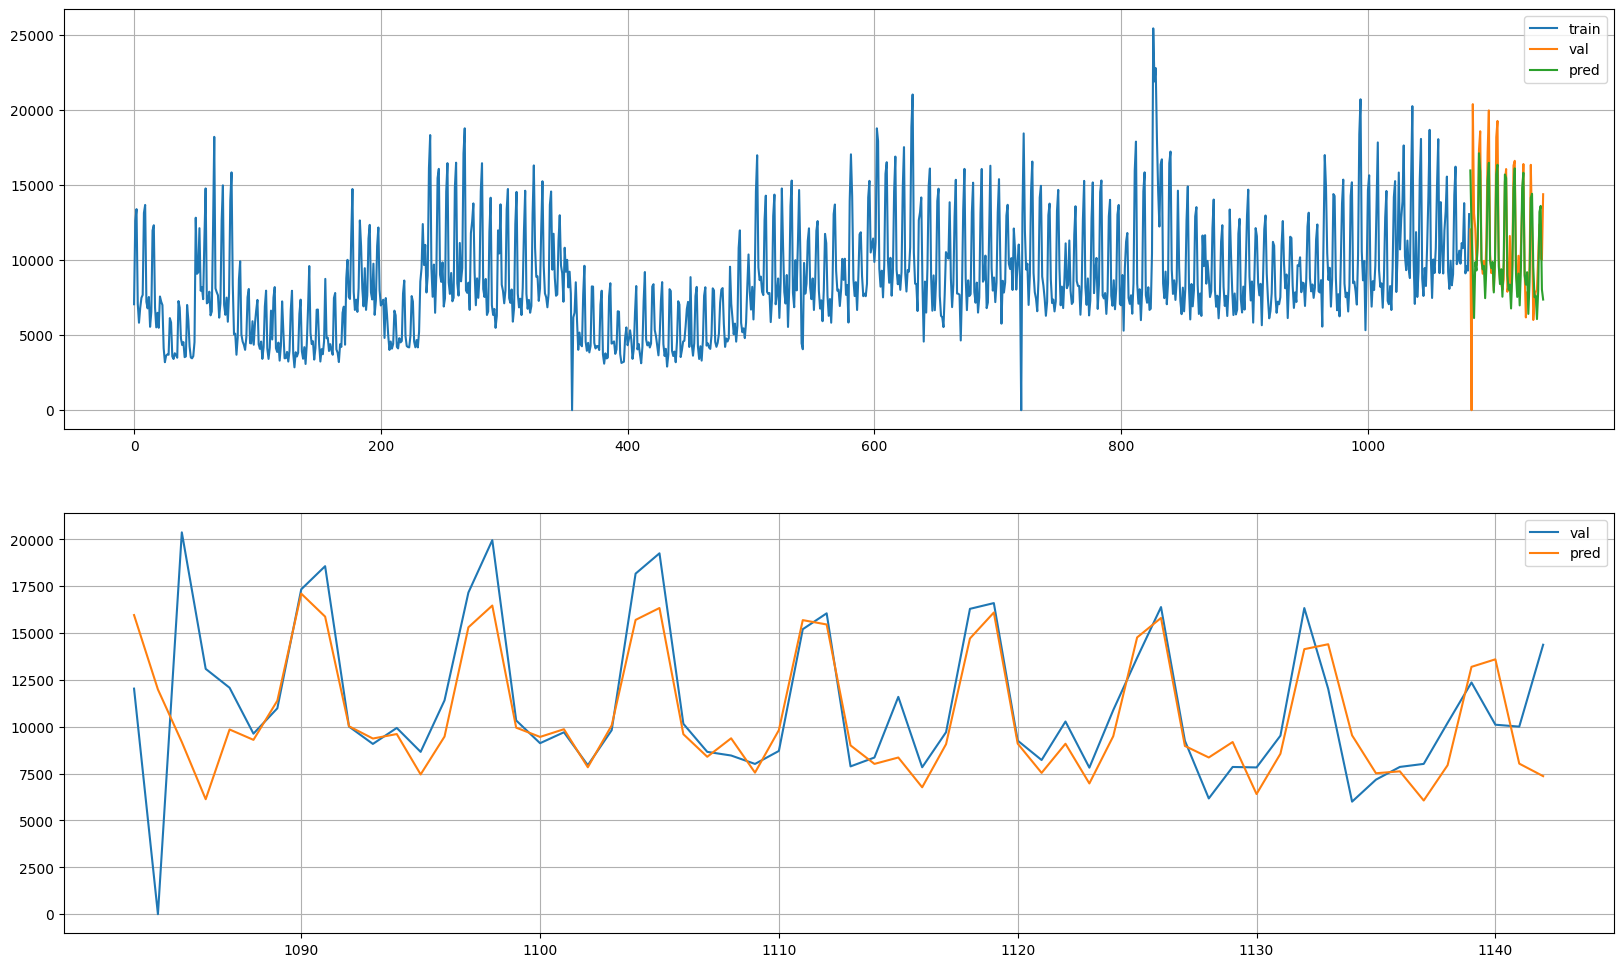

In [68]:
pred = model.predict(X_valid_s)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

plot_model_result(y_train, y_valid, pred)

In [69]:
# 평가
print('RMSE:', round(mean_squared_error(y_valid, pred, squared=False), 2))
print('MAE :', round(mean_absolute_error(y_valid, pred), 2))
print('MAPE:', round(mean_absolute_percentage_error(y_valid, pred), 2))
print('R2  :', round(r2_score(y_valid, pred), 2))

RMSE: 2926.74
MAE : 1780.89
MAPE: 8.996964267501901e+17
R2  : 0.46


### **2) 상품 : 12 - Milk**

* **데이터 준비**

In [70]:
target = 'y'
val_size = 60
timesteps = 7

X_train, X_valid, y_train, y_valid, X_train_s, X_valid_s, y_train_s, y_valid_s, scaler_y = data_split2(df_12, target, val_size, timesteps)

In [71]:
X_train_s.shape, X_valid_s.shape, y_train_s.shape, y_valid_s.shape

((1083, 7, 11), (60, 7, 11), (1083, 1), (60, 1))

* **모델링**

In [72]:
nfeatures = X_train_s.shape[2]
epochs = 50

history, model = CNN_model_training(nfeatures, epochs, timesteps)

Epoch 1/50
28/28 [==============================] - 1s 9ms/step - loss: 0.0107 - val_loss: 0.0085
Epoch 2/50
28/28 [==============================] - 0s 4ms/step - loss: 0.0059 - val_loss: 0.0034
Epoch 3/50
28/28 [==============================] - 0s 4ms/step - loss: 0.0052 - val_loss: 0.0044
Epoch 4/50
28/28 [==============================] - 0s 5ms/step - loss: 0.0054 - val_loss: 0.0048
Epoch 5/50
28/28 [==============================] - 0s 4ms/step - loss: 0.0051 - val_loss: 0.0048
Epoch 6/50
28/28 [==============================] - 0s 4ms/step - loss: 0.0050 - val_loss: 0.0049
Epoch 7/50
28/28 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0036
Epoch 8/50
28/28 [==============================] - 0s 3ms/step - loss: 0.0045 - val_loss: 0.0045
Epoch 9/50
28/28 [==============================] - 0s 3ms/step - loss: 0.0047 - val_loss: 0.0036
Epoch 10/50
28/28 [==============================] - 0s 3ms/step - loss: 0.0045 - val_loss: 0.0048
Epoch 11/50
28/28 [

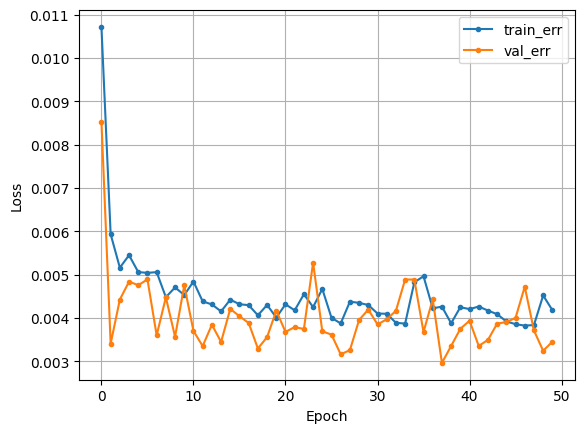

In [73]:
dl_history_plot(history)

2/2 [==============================] - 0s 6ms/step


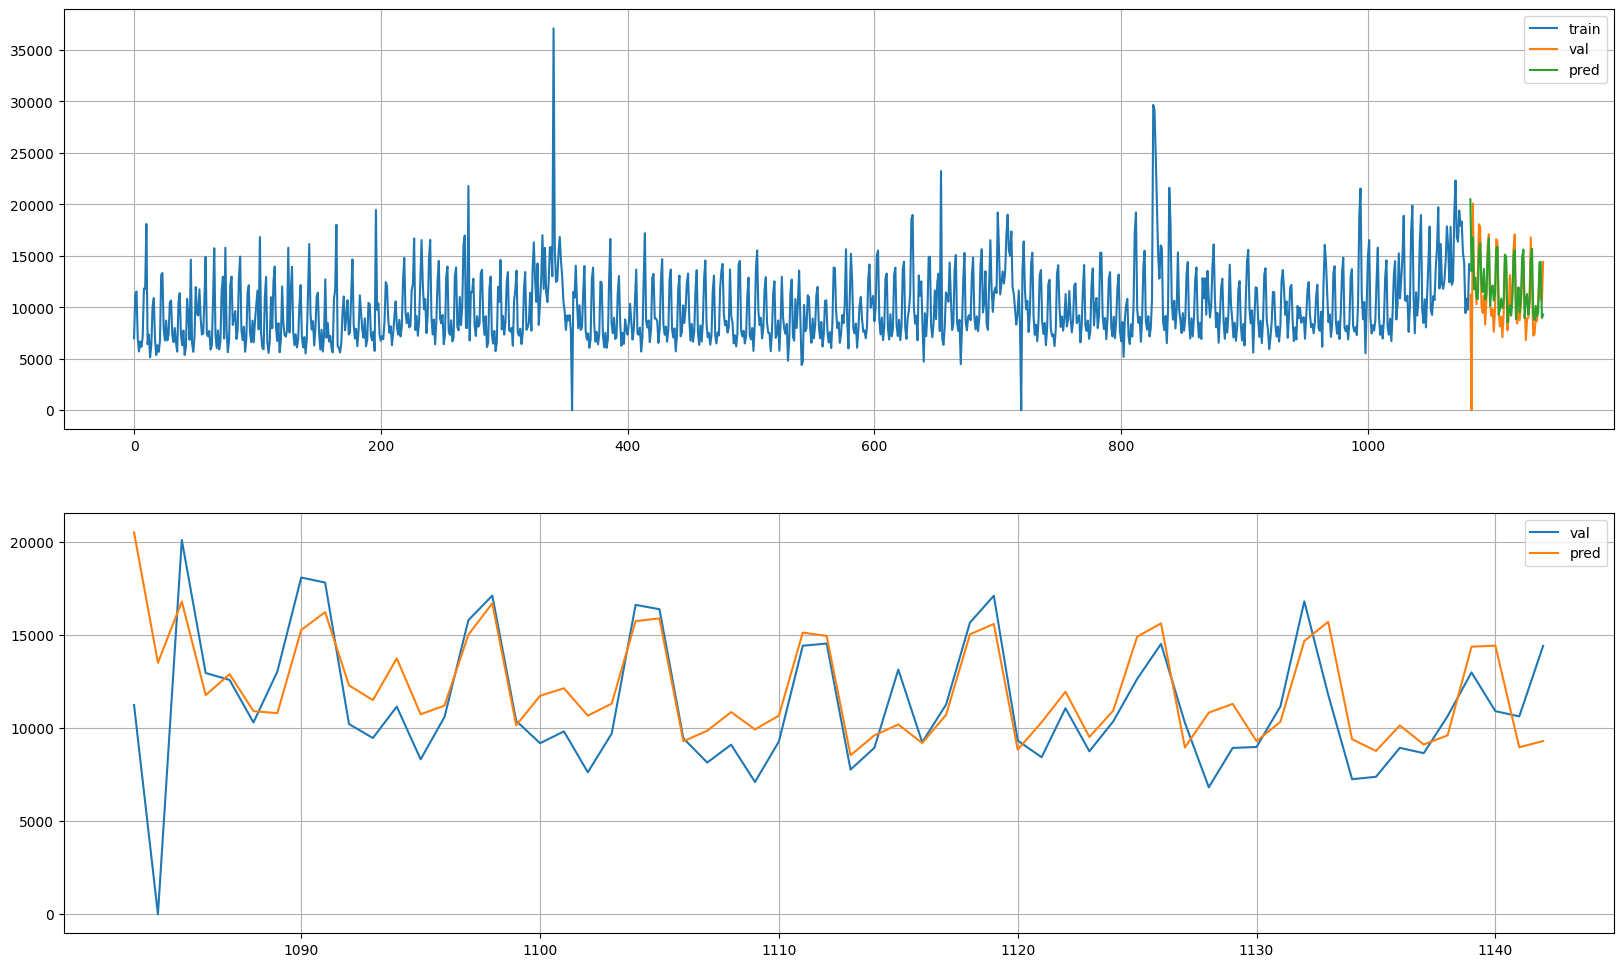

In [74]:
pred = model.predict(X_valid_s)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

plot_model_result(y_train, y_valid, pred)

In [75]:
# 평가
print('RMSE:', round(mean_squared_error(y_valid, pred, squared=False), 2))
print('MAE :', round(mean_absolute_error(y_valid, pred), 2))
print('MAPE:', round(mean_absolute_percentage_error(y_valid, pred), 2))
print('R2  :', round(r2_score(y_valid, pred), 2))

RMSE: 2830.4
MAE : 1893.83
MAPE: 1.0131733568141919e+18
R2  : 0.35


### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

In [76]:
target = 'y'
val_size = 60
timesteps = 7

X_train, X_valid, y_train, y_valid, X_train_s, X_valid_s, y_train_s, y_valid_s, scaler_y = data_split2(df_42, target, val_size, timesteps)

In [77]:
X_train_s.shape, X_valid_s.shape, y_train_s.shape, y_valid_s.shape

((1086, 7, 11), (60, 7, 11), (1086, 1), (60, 1))

* **모델링**

In [78]:
nfeatures = X_train_s.shape[2]
epochs = 50

history, model = CNN_model_training(nfeatures, epochs, timesteps)

Epoch 1/50
28/28 [==============================] - 1s 8ms/step - loss: 0.0416 - val_loss: 0.0163
Epoch 2/50
28/28 [==============================] - 0s 4ms/step - loss: 0.0081 - val_loss: 0.0106
Epoch 3/50
28/28 [==============================] - 0s 4ms/step - loss: 0.0073 - val_loss: 0.0116
Epoch 4/50
28/28 [==============================] - 0s 3ms/step - loss: 0.0074 - val_loss: 0.0095
Epoch 5/50
28/28 [==============================] - 0s 3ms/step - loss: 0.0074 - val_loss: 0.0111
Epoch 6/50
28/28 [==============================] - 0s 4ms/step - loss: 0.0072 - val_loss: 0.0096
Epoch 7/50
28/28 [==============================] - 0s 4ms/step - loss: 0.0068 - val_loss: 0.0097
Epoch 8/50
28/28 [==============================] - 0s 3ms/step - loss: 0.0065 - val_loss: 0.0103
Epoch 9/50
28/28 [==============================] - 0s 3ms/step - loss: 0.0069 - val_loss: 0.0089
Epoch 10/50
28/28 [==============================] - 0s 3ms/step - loss: 0.0065 - val_loss: 0.0093
Epoch 11/50
28/28 [

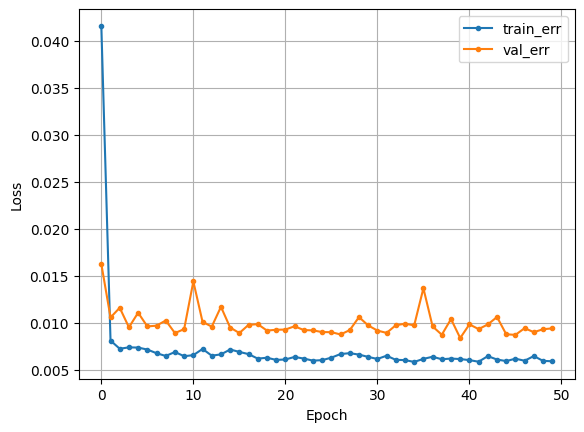

In [79]:
dl_history_plot(history)

2/2 [==============================] - 0s 7ms/step


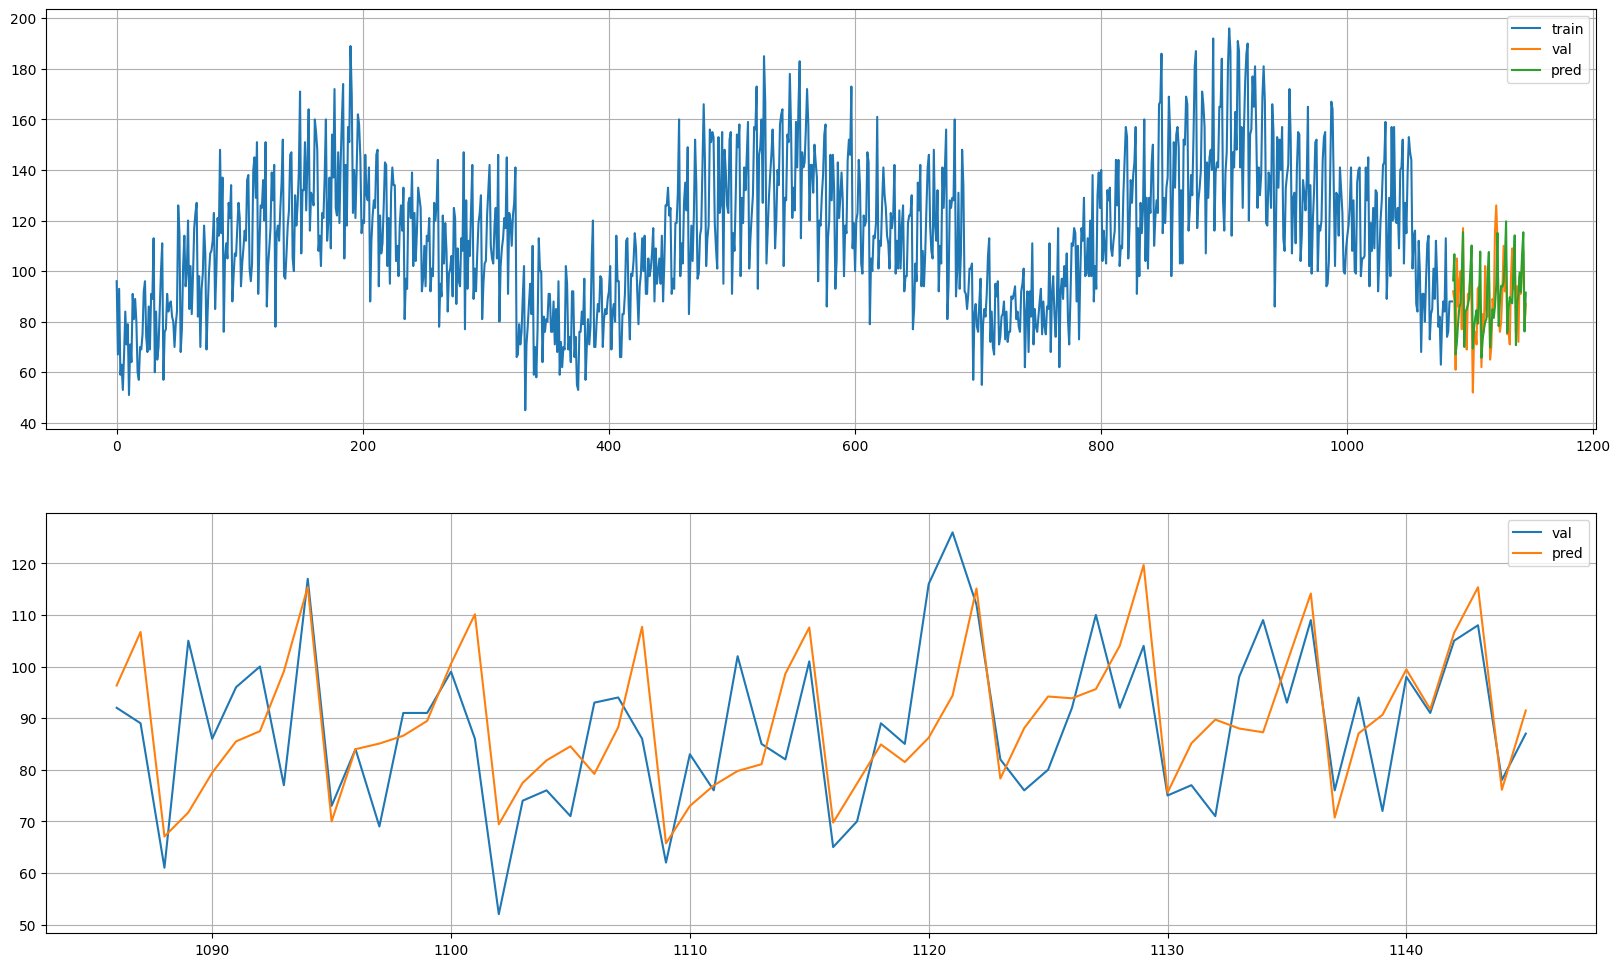

In [80]:
pred = model.predict(X_valid_s)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

plot_model_result(y_train, y_valid, pred)

In [81]:
# 평가
print('RMSE:', round(mean_squared_error(y_valid, pred, squared=False), 2))
print('MAE :', round(mean_absolute_error(y_valid, pred), 2))
print('MAPE:', round(mean_absolute_percentage_error(y_valid, pred), 2))
print('R2  :', round(r2_score(y_valid, pred), 2))

RMSE: 12.82
MAE : 9.82
MAPE: 0.11
R2  : 0.29


# **5.데이터 저장**

* **세부 요구사항**
    * 상품코드별 데이터셋을 저장하시오.
    * joblib.dump를 이용하시오.
    * 저장할 파일의 확장자는 보통 .pkl 입니다.

In [82]:
joblib.dump(df_3, 'data/df_3.pkl')

['data/df_3.pkl']

In [83]:
joblib.dump(df_12, 'data/df_12.pkl')

['data/df_12.pkl']

In [84]:
joblib.dump(df_42, 'data/df_42.pkl')

['data/df_42.pkl']